In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import jqdatasdk as jq
import os

# 请在环境变量中设置聚宽账号。账号可在jointquant.com上免费申请
account = os.environ.get('JQ_ACCOUNT')
password = os.environ.get('JQ_PASSWORD')
securities = jq.get_all_securities()

提示：当前环境pandas版本为0.25，get_price与get_fundamentals_continuously接口panel参数将固定为False
注意：0.25以上版本pandas不支持panel，如使用该数据结构和相关函数请注意修改
auth success 


谁都希望买在底部，卖在顶点。作为一个有经验的老手，你知道预测底部和顶部实际上是不可能的。但是，能否在一支个股刚刚走出底部或者顶部形态的时候就做出提示呢？这是目前市面上，所有软件都没有的一个功能。不是所有的顶底都可以预测，但是，但出现圆弧底或者圆弧顶时，这种顶或者底往往都是比较明确的。那么，我们如何通过软件来从几千只个股中来发现这种圆弧底（顶）呢？

比较容易想到的方法当然是通过神经网络，我们知道CNN网络有很强大的图像识别能力，有经验的人能看出来的顶或者底，它也应该能看出来。这一部分我们将放到后面的章节来讲。除了这些高级技巧之外，就我们现在掌握的工具，有没有办法发现这一点?

首先，我们来回顾一点数学知识：

Text(0, -60, 'B')

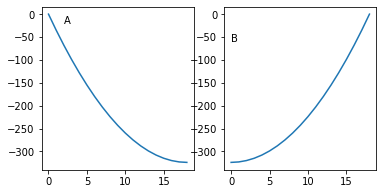

In [24]:
a = [x**2 - 36 * x for x in range(0,19)]
b = [x**2 - 36 * x for x in range(18,37)]

plt.figure(figsize=(6,3))
plt.subplot(121)
plt.plot(a)
plt.text(2,-20, 'A')
plt.subplot(122)
plt.plot(b)
plt.text(0, -60, 'B')

上面的图A和图B，虽然方向相同，但它们实际上都是同一条曲线 **_y = x^2-36x_** 的一部分。左边的曲线，x取值从0到18；右边的曲线，x取值从19到36.

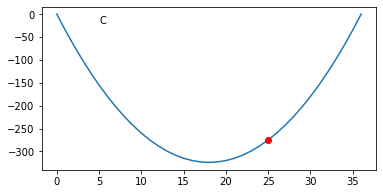

In [34]:
plt.figure(figsize=(6,3))
c = [x**2 - 36 * x for x in range(0,37)]

plt.plot(c)
plt.text(5, -20, 'C')
plt.plot(25, 25*25 - 36*25, 'o',color='r')

In [ ]:
ma = moving_average(close, 5)
# 这里ma是一个numpy数组,numpy数组可以与标量进行element-wise操作，这被称之为广播
ts = ma/ma[0]

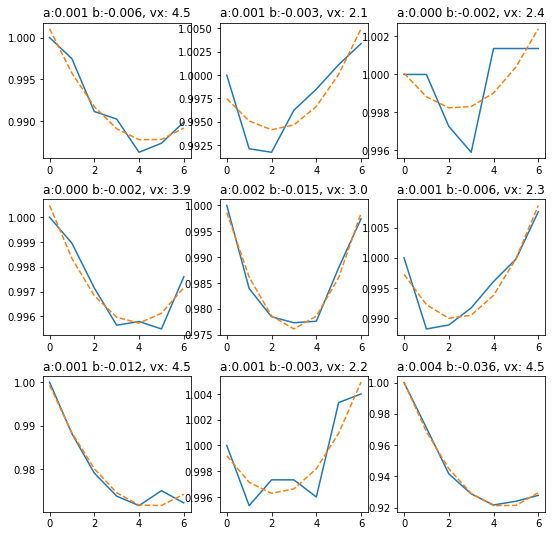

In [48]:
def moving_average(ts, win):
    return np.convolve(ts, np.ones(win)/win, 'valid')


def rmse(y, y_hat):
    """
    返回预测序列相对于真值序列的标准差。
    Args:
        y:
        y_hat:

    Returns:

    """
    return np.sqrt(np.mean(np.square(y - y_hat)))

def find_parabola(unit='1d', a = 0, e=3e-3, fit_win=7):
    x = np.arange(7)
    fields = ['date', 'close', 'open','volume']
    
    # 设置与显示相关的参数
    plt.figure(figsize=(9,9))
    plt.subplots_adjust(hspace=0.3)

    count = 0
    for code in securities.index:
        bars = jq.get_bars(code, fit_win + 5 - 1, unit=unit, include_now=True, df=False, fields=fields)
        if len(bars) != fit_win + 5 -1:
            continue
            
        ma = moving_average(bars['close'], 5)
        ts = ma/ma[0]
        coef = np.polyfit(x, ts, deg=2)
        p = np.poly1d(coef)
        ts_hat = np.array([p(xi) for xi in x])
        err = rmse(ts, ts_hat) / np.sqrt(np.mean(np.square(ts)))
        if err > e:
            continue
        
        _a,_b,_c = coef
        vert_x = -_b / (2 * _a)
        t1 = _a > a and (fit_win-2)>vert_x > 2
        # 如果是用于实际选股，你还需要加上其它条件，比如当前收阳，或者量能增加等
        #         if not t1:
        #             continue
        #         vol_up = bars['volume'][-4:-1]>bars['volume'][-5:-2]

        #         t2 = np.count_nonzero(vol_up) >= 2
        #         if not t2:
        #             continue

        #         ups = bars['close'][-3:]>bars['open'][-3:]
        #         t3 = np.count_nonzero(ups) == 3
        #         if not t3:
        #             continue

        # 作为示例，我们只输出9张图
        if count >= 9:
            break
            
        if t1:
            count += 1
            
            ax = plt.subplot(int(f"33{count}"))
            # 显示股票代码，为避免推广嫌疑，这里注释掉。读者在运行时可以自己打开。
            # ax.set_title(code)
            ax.set_title(f"a:{_a:.3f} b:{_b:.3f}, vx: {vert_x:.1f}")
            plt.plot(x, ts)
            plt.plot(x, ts_hat, '--')
            
        
find_parabola()

在上图中，实线是实际的均线，而虚线则是拟合的曲线。有一些图显然居然能够拟合的这么好！我们能这样猜测，这些图形是主力已经控盘，并且主动洗盘留下的痕迹吗？

还有一些地方需要讨论。

比如，这里的横坐标是什么意思呢？我们是拿7天的均线来做的拟合（因为用的5“日”均线，所以取收盘价时取了11天），所以横坐标为0的时候，代表7天前。那么当最低点落在x=4时，意味着两天前均线到达最低点位置。我们留了两天的时间来确认这个底部已经真的走出来了。

函数中有一个参数，fit_win，就是我们最终用于拟合的均线数据点数。我的推荐是7，太短，则可能出现假信号，但也可能捕捉到最近上涨趋势比较大的个股；太长，则可能出现的信号较少。记住，当我们取fit_win=7,均线窗口为5时，实际上我们是使用了最近11天的交易数据进行预测，这个时间在短线中并不算短了。

我并没有推荐a、b、拟合误差和从低点上来到信号确认的等待时间这些参数的默认值。你需要自己去发现它。最好的方法是使用机器学习来寻找这两个参数。我相信，不同的个股，因为操盘的主力风格不一样，这些参数很可能也是不一样的。

最后， 如果把上面的图形垂直翻转过来，就成为圆弧顶。当股价大幅拉升之后，主力出货最有利的选择，就是做圆弧顶（如果急跌，则反倒是洗盘）。在圆弧顶的初期阶段，由于下跌的绝对值很小，普通投资者很容易忽略它，或者觉得可以忍受，但主力已悄悄地在高位将筹码交给了你。更可怕地是，这种下跌是一种加速运动，起初不起眼，但背后蕴藏了巨大的下跌动能，并最终会引发一场雪崩。

2020年的7月，前半段是天使，后半段是魔鬼。很多股民在7月底赔了钱，交出了筹码。很多人不知道这里隐藏了巨大的风险，或者不知道应该在何时撤出股市。下面，如果我把7月13日前后上证指数30分钟线的20日线画给你看，告诉你应该何时离场，你会不会有醍醐灌顶的感觉？

In [61]:
shbars = jq.get_bars('000001.XSHG', 90, '30m', end_dt='2020-7-18')

Text(45.94027618728799, 1.0643946452139237, '2020-07-14 15:00:00')

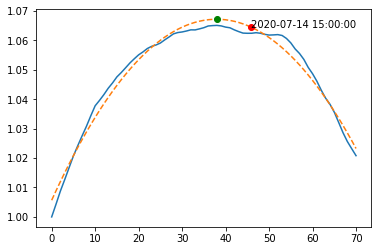

In [67]:
ma = moving_average(shbars['close'], 20)
ts = ma/ma[0]
coef = np.polyfit(np.arange(len(ts)), ts, deg=2)
p = np.poly1d(coef)
ts_hat = [p(x) for x in range(len(ts))]
plt.plot(ts)
plt.plot(ts_hat, '--')

a,b,c = coef
vert_x = -b/(2*a)
plt.plot(vert_x, p(vert_x), 'o', color='g')

leave = vert_x + 8
plt.plot(leave, p(leave), 'o', color='r')
plt.text(leave, p(leave), shbars['date'][20 + int(leave)])

可以看到，实际走势跟拟合曲线几乎完全一致！上证指数的走势，就好象在7月6日前后，主力向天空抛掷了一块石子，这块石子在7月13日左右达到顶点，然后慢慢下落，速度越来越快，遵循自由落体定律。而我们最好的离场时机，正如图中红点所揭示，2020年7月14日，15：00。

我把这个策略称为动量策略。因为它寻找的是运动的加速度，或者说时间序列的二阶导数。股价运行方向看似在变化，但其背后却实际上隐藏了一个常量，从而使得我们可以比较容易地捕捉到它。这正是量化的魅力。

尽管在实际操作中，我们可能还要结合量能、最后几根k线的走势来决定操作方向，但毫无疑问，这一章揭示的规律，是有着合理的解释、十分有效和强大的。如果读者自己有编程基础，可以象往常一样，在github上下载配套源码；如果自己没有编程基础，资金量还比较大的话，建议你可以找身边的IT人来自己实现这个策略。